# Определение успешности игры для интернет магазина.

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года. В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Общая информация о данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
# небольшая функция, которой обычно пользуюсь...
def df_info(df_name):
    display(df_name.head())
    display(df_name.info())
    display(df_name.describe())
    display(df_name.duplicated().sum())   

In [4]:
df_info(games)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


0

Посмторим наличие неявных дубликатов в столбцах Platform, Genre и Rating. Столбец Name разберем позже, ибо для его обработки нам сначала потребуется предворительные действия. 

In [5]:
games['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [6]:
check = ['Platform', 'Genre', 'Rating']

for i in games[check]: 
    print(games[i].unique())
    print()

['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']

['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']



Пока все чисто...

**Вывод:**

    - Названия столбцов имеют заглавные буквы.
    - Видим довольно большое кол-во пропусков.
    - Year_of_Release имеет формат float, а должен быть int.
    - User_Score - имеет тип object, а должен быть float.

In [7]:
# Комментарий ревьюера
temp = games.copy()
temp[temp[['Name', 'Platform','Year_of_Release']].duplicated(keep=False)]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


## Подготовка данных

### Заменим названия столбцов (приведем к нижнему регистру).

In [8]:
games.columns = games.columns.str.lower()

Приведем к нижнему регистру некоторые столбцы, чтобы исключить неявные дубликаты. 

In [9]:
for column in games[['name','platform','genre','rating']]:
    games[column] = games[column].str.lower()

Теперь можем проверить значения столбца name на наличие дубликатов. Однако необходимо сделать сводную таблицу, содержащюу как название игры, так и название платформы с годом выхода (не забываем про ремейки), ибо одна игра может выхолить для разных платформ и перевыпускаться.  

In [10]:
name_check = games[['name', 'platform', 'year_of_release']]
name_check

,name,platform,year_of_release
0,wii sports,wii,2006.0
1,super mario bros.,nes,1985.0
2,mario kart wii,wii,2008.0
3,wii sports resort,wii,2009.0
4,pokemon red/pokemon blue,gb,1996.0
...,...,...,...
16710,samurai warriors: sanada maru,ps3,2016.0
16711,lma manager 2007,x360,2006.0
16712,haitaka no psychedelica,psv,2016.0
16713,spirits & spells,gba,2003.0


In [11]:
name_check[name_check.duplicated()]

,name,platform,year_of_release
14244,NaN,gen,1993.0
16230,madden nfl 13,ps3,2012.0


Всего один дубликат, это хорошо. Посмотрим чем оно отличаются в нашей основной БД.

In [12]:
games.query('name == "madden nfl 13" and platform == "ps3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,ps3,2012.0,sports,2.11,0.22,0.0,0.23,83.0,5.5,e
16230,madden nfl 13,ps3,2012.0,sports,0.00,0.01,0.0,0.00,83.0,5.5,e


Это явно одна и та же игра, однако у нашего допенгальгера плоховато с продажами. Не вижу причин оставлять эту строку, удалим ее.

In [13]:
games = games.drop(index=[16230])

### Преобразуем данные в нужные типы. 

Посмотрим какие значения в себе содержит столбец `critic_score`.

In [14]:
games['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Видим тольцо целые значения 

TBD - аббревиатура от английского To Be Decided (будет решено, скорее всего либо не было отзывов вообше, либо их было очень мало для формирования рейтинга. Заменим значение `tbd` на NaN.

In [15]:
games['user_score'] = games['user_score'].replace('tbd', np.NaN)
games['user_score'] = games['user_score'].astype('float')

И еще пара столбцов, с которыми нужно разобраться.

In [16]:
games['year_of_release'] = games['year_of_release'].astype('Int64')
games['critic_score'] = games['critic_score'].astype('Int64')

### Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец.

In [17]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [18]:
games.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76,8.0,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82,8.3,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80,8.0,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,31.38
5,tetris,gb,1989,puzzle,23.20,2.26,4.22,0.58,<NA>,NaN,NaN,30.26
6,new super mario bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89,8.5,e,29.80
7,wii play,wii,2006,misc,13.96,9.18,2.93,2.84,58,6.6,e,28.91
8,new super mario bros. wii,wii,2009,platform,14.44,6.94,4.70,2.24,87,8.4,e,28.32
9,duck hunt,nes,1984,shooter,26.93,0.63,0.28,0.47,<NA>,NaN,NaN,28.31


### Обработаем пропуски.

Сейчас точно можно сделать замену пропусков в стобцах `name` и `genre` т.к. на последующие вычесления они не повлияют, остальные пропуски пока оставим. Пропуски могли возникнуть по многим причинам, например: невелся опрос с оценкой игры, игра не популярна и ее никто не оценивал, техничская ошибка и прочее.

In [19]:
games[games['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
659,NaN,gen,1993,NaN,1.78,0.53,0.00,0.08,<NA>,NaN,NaN,2.39
14244,NaN,gen,1993,NaN,0.00,0.00,0.03,0.00,<NA>,NaN,NaN,0.03


Два из двух, удаляем эти строчки.  

In [20]:
games = games.dropna(subset = ['name'])

Рейтинг ESRB - это рейтинг для США и Канады, значит пропуски не савязаны с ошибкой заполнения данных, просто не только для Северной Америки выпускаются игры. В столбце rating заменим пропуски на "не определено", так будет легче рабоатать с данными.

In [21]:
games["rating"] = games['rating'].fillna("undefined")

Теперь пропуски в столбце year_of_release.

In [22]:
print('Кол-во NaN:',games['year_of_release'].isna().sum())
print('Процент NaN:', round(games['year_of_release'].isna().mean()*100,2),'%')

Кол-во NaN: 269
Процент NaN: 1.61 %


Пропуски в столбце year_of_release составляют 1.61%, однако эти пробелы могли вознкинуть в результате технической ошибки. Возьмем более узкий круг данных. Скажем, если игра не имеет информации о дате релиза оценок критиков и оценок пользователей, а так же имеет малые продажи (определим в 100к копий), то удалим данные игры из нашей БД. Думаю, это максимально сбалансированный подход.

In [23]:
games.query('year_of_release.isna() and critic_score.isna() and user_score.isna() and total_sales <= 0.1')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
10317,happy feet two,ps3,<NA>,action,0.09,0.00,0.00,0.01,<NA>,NaN,undefined,0.10
10486,atsumare! power pro kun no ds koushien,ds,<NA>,sports,0.00,0.00,0.10,0.00,<NA>,NaN,undefined,0.10
10612,my healthy cooking coach,ds,<NA>,simulation,0.09,0.00,0.00,0.01,<NA>,NaN,e,0.10
10686,happy feet two,ds,<NA>,action,0.08,0.01,0.00,0.01,<NA>,NaN,e,0.10
10764,luminous arc 2 (jp sales),ds,<NA>,role-playing,0.00,0.00,0.10,0.00,<NA>,NaN,undefined,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...
16288,shorts,ds,<NA>,platform,0.01,0.00,0.00,0.00,<NA>,NaN,e10+,0.01
16293,akb1/48: idol to guam de koishitara...,x360,<NA>,misc,0.00,0.00,0.01,0.00,<NA>,NaN,undefined,0.01
16329,brothers in arms: furious 4,x360,<NA>,shooter,0.01,0.00,0.00,0.00,<NA>,NaN,m,0.01
16348,agarest senki: re-appearance,ps3,<NA>,role-playing,0.00,0.00,0.01,0.00,<NA>,NaN,undefined,0.01


In [24]:
bad_lines_index = games.query('year_of_release.isna() and critic_score.isna() and user_score.isna() and total_sales <= 0.1').index
bad_lines_index

Int64Index([10317, 10486, 10612, 10686, 10764, 10790, 10837, 10993, 11000,
            11016, 11092, 11338, 11377, 11433, 11622, 11790, 12209, 12235,
            12524, 12568, 12734, 12880, 12959, 13060, 13289, 13317, 13564,
            13609, 13647, 13711, 13874, 13929, 14105, 14126, 14252, 14325,
            14350, 14369, 14449, 14597, 14749, 14931, 14950, 15022, 15079,
            15081, 15119, 15267, 15338, 15557, 15675, 15704, 15795, 15953,
            15998, 16017, 16059, 16079, 16288, 16293, 16329, 16348, 16458],
           dtype='int64')

In [25]:
games.drop(bad_lines_index, inplace = True)

Что касается пропусков в столбцах critic_score и user_score, то во первых, их процент слишком высок, чтобы из удалять. Во вторых, пропуски в этих столбцах могут быть обусловлены малыми продажами и, как следствие, недостаточным количеством отзывов об игре, чтобы сформулировать оценку. Поэтому, оставляем как есть.

**Вывод:**

Заменили названия столбцов, а именно - привели их к нижнему регистру, преобразовали данные в нужные типы, обработали пропуски в БД и добавили столбец, содержащий сумарные продажи во всех регионах. Первичная обработка и анализ данных завершена.

## Исследовательский анализ данных

### Посмотрим, сколько игр выпускалось в разные годы и узнаем важны ли данные за все периоды.

Для начала посмотрим на количество игр, выпущенные по годам.

In [27]:
year_of_release_list = pd.pivot_table(games, index = 'year_of_release', values = 'name', aggfunc = 'count')
year_of_release_list.columns = ['games_released']
year_of_release_list

,games_released
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


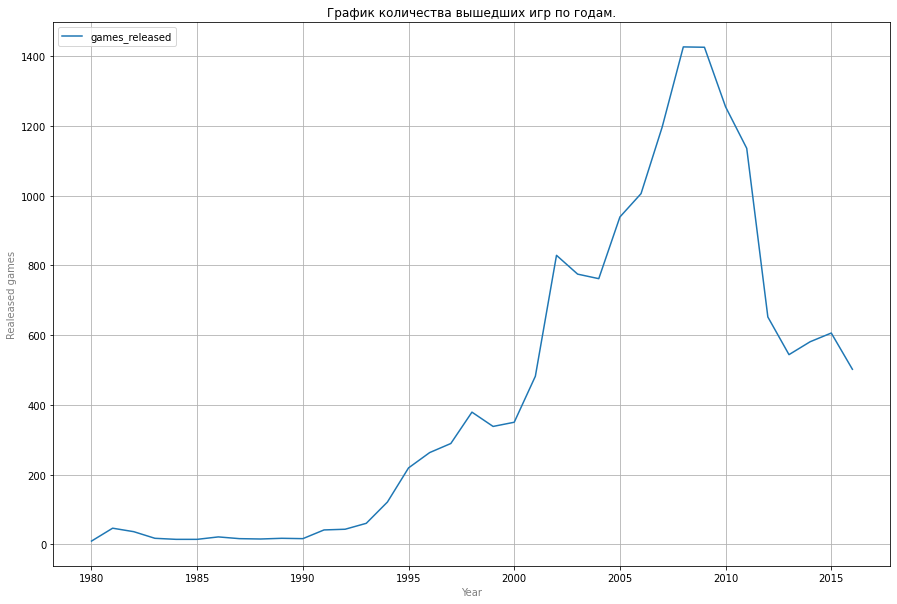

In [28]:
year_of_release_list.plot(figsize = (15, 10))

plt.legend(loc=2)
plt.title('График количества вышедших игр по годам.')
plt.xlabel('Year', color='gray')
plt.ylabel('Realeased games',color='gray')
plt.grid(True)
plt.show()

Сложно сказать, про важность данных за все периоды. Пока мы можем лишь пронаблюдать значения. Видим, что, в целом, количество игр 1980-го по 2011 постепеноо росло, и лишь в 2012 появилась тенденция на спад производства игр (Если не ошибаюсь, это год релиза ps4 и хуанкоробки, что повлияло на рынок, хотя может во всем винот мобильный гейминг..). А важность данных по периодам будем определять по мере поступления задач.

### Посмотрим, как менялись продажи по платформам и выберем платформы с наибольшими суммарными продажами.

In [29]:
platforms_sales = games.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False)
platforms_sales

,total_sales
platform,
ps2,1255.53
x360,971.14
ps3,939.37
wii,907.00
ds,805.12
ps,730.73
gba,317.85
ps4,314.14
psp,293.81


Непревзайденный лидер на данный момент ps2 c больше чем миллиардом проданных копий, далее идут: x360, ps3, wii, ds, ps.

In [30]:
pd.set_option('display.max_rows', None)

platform_sales_per_year = games.pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum')
print(platform_sales_per_year)

pd.set_option('display.max_rows', 10)

                          total_sales
platform year_of_release             
2600     1980                   11.38
         1981                   35.68
         1982                   28.88
         1983                    5.84
         1984                    0.27
         1985                    0.45
         1986                    0.67
         1987                    1.94
         1988                    0.74
         1989                    0.63
3do      1994                    0.02
         1995                    0.08
3ds      2011                   63.20
         2012                   51.36
         2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
dc       1998                    3.38
         1999                    5.16
         2000                    5.99
         2001                    1.07
         2002                    0.29
         2007                    0.02
         200

Не наблюдается единой тенденции продаж платформ. Видимо все зависит от множества факторов, на подобии релиза громкого игрового хита, маркетинга, в целом количества произведенных платформ.

In [31]:
platform_sales_per_year = platform_sales_per_year.reset_index()
platform_longevity = platform_sales_per_year.pivot_table(index=['platform'], values='year_of_release', aggfunc='count')
print(platform_longevity['year_of_release'].mean())

7.67741935483871


Средняя продолжительность жизни платформы = 7-8 лет

In [32]:
# Комментарий ревьюера
temp = games.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median(), time_life['life'].mean()

(7.0, 8.612903225806452)

### Исследуем данные за соответствующий актуальный период.

Т.к. такой динамично меняющейся индустрии, как компьютерные игры не стоит брать слишком большой временной интервал - иначе обязательно захватим уже отжившие тренды. Актуальный период 2012 - 2016 т.к. Выборка будет достаточно большой и ближе к исследуемому периоду (2017 год).

In [33]:
explore_period = games.query('year_of_release >= 2012') 

Графики по количеству выпущенных игр за актуальный период на разных платформах

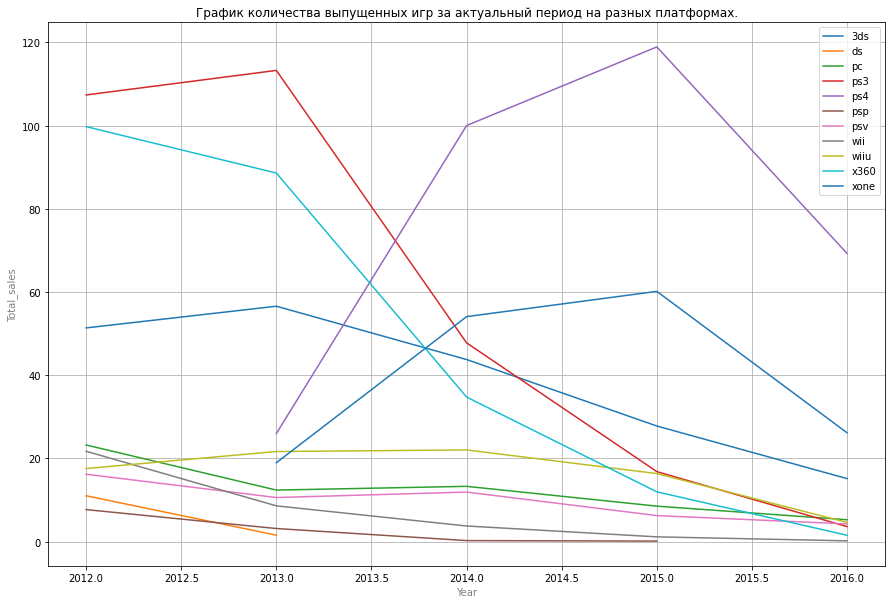

In [34]:
explore_period.pivot_table(index = 'year_of_release', columns = 'platform', values = 'total_sales', aggfunc = 'sum').plot(figsize = (15, 10))

plt.legend(loc=1)
plt.title('График количества выпущенных игр за актуальный период на разных платформах.')
plt.xlabel('Year', color='gray')
plt.ylabel('Total_sales',color='gray')
plt.grid(True)
plt.show()

Подтвердили ранее полученную информацию, что игры на платформах идут на снижение по продажам. PS4 и XOne являются потенциально прибыльными на период 2017 года, однако падение продаж все равно будет продолжаться (ждем релизов новых консолей). Падает сильнее всего спрос на консоли: X360, PS3. На остальные консоли уже давно упал спрос.

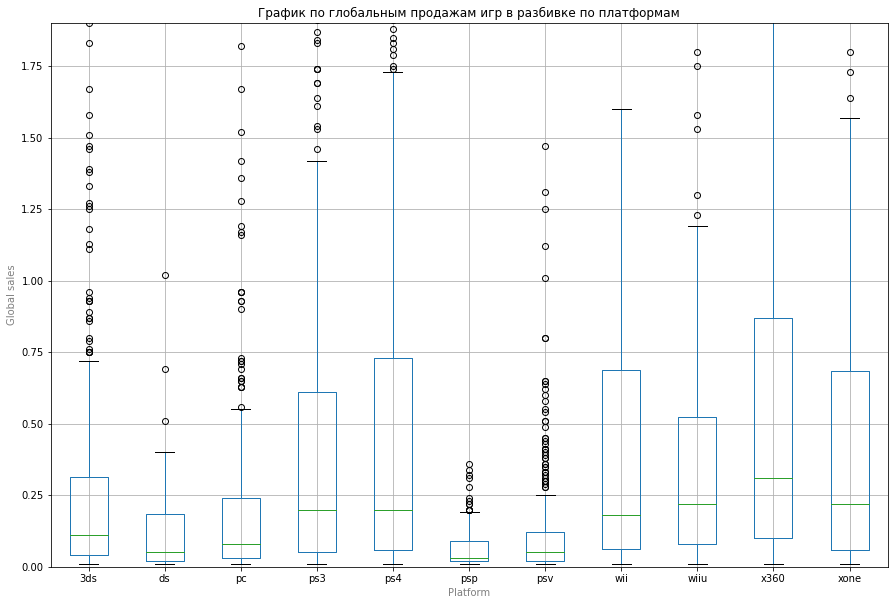

In [35]:
explore_period.pivot_table(index = 'name', columns = 'platform', values = 'total_sales', aggfunc = 'sum').plot(kind = 'box', ylim = (0,1.9), figsize = (15, 10))

plt.title('График по глобальным продажам игр в разбивке по платформам')
plt.xlabel('Platform', color='gray')
plt.ylabel('Global sales',color='gray')
plt.grid(True)
plt.show()

Наблюдаем тотальное доминирование "свежих" и не очень консолей от Sony и Microsoft. PC гейминг, на мое удивление, далек от них, хотя его можно назвать самым стабильным...

### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.

В нашей выборке наиболее показательными будут ps4 и xone. т.к количесство информации по этим консолям достаточное. Возьмем ps4.

In [36]:
def score_scatter(platform_name):
    best_console = explore_period.query('platform == @platform_name')
    best_console.plot(kind = 'scatter', x = 'user_score', y = 'total_sales', figsize = (15,10))

    plt.title(f'График зависимости продаж от оценки критиков {platform_name}')
    plt.xlabel('Score', color='gray')
    plt.ylabel('Total_sales',color='gray')
    plt.grid(True)
    plt.show()
    
    best_console.plot(kind = 'scatter', x = 'critic_score', y = 'total_sales', figsize = (15,10))

    plt.title(f'График зависимости продаж от оценки критиков {platform_name}')
    plt.xlabel('Score', color='gray')
    plt.ylabel('Total_sales',color='gray')
    plt.grid(True)
    plt.show()
    
    best_console_cor = best_console[['critic_score','user_score', 'total_sales']]
    print('Корреляция', platform_name)
    print(best_console_cor.corr())
    print('-'*115)

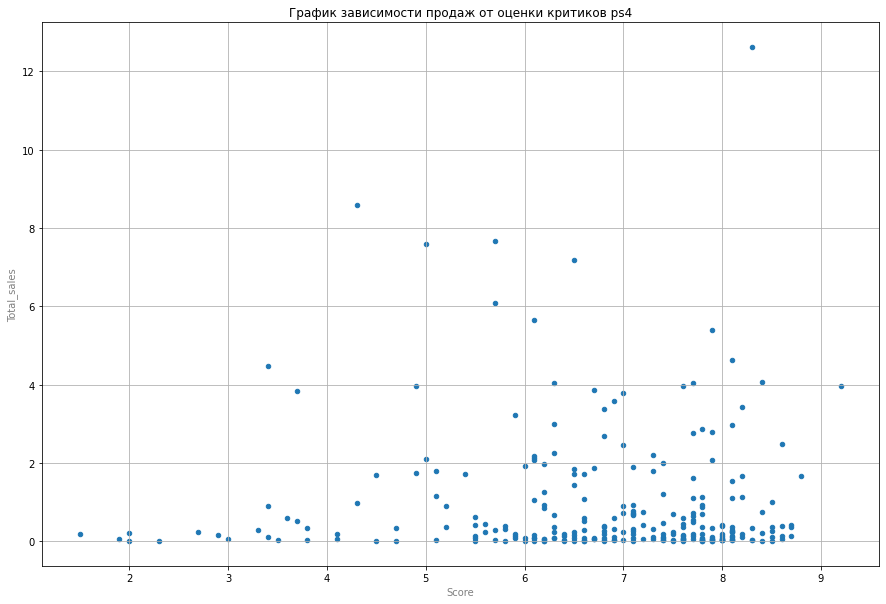

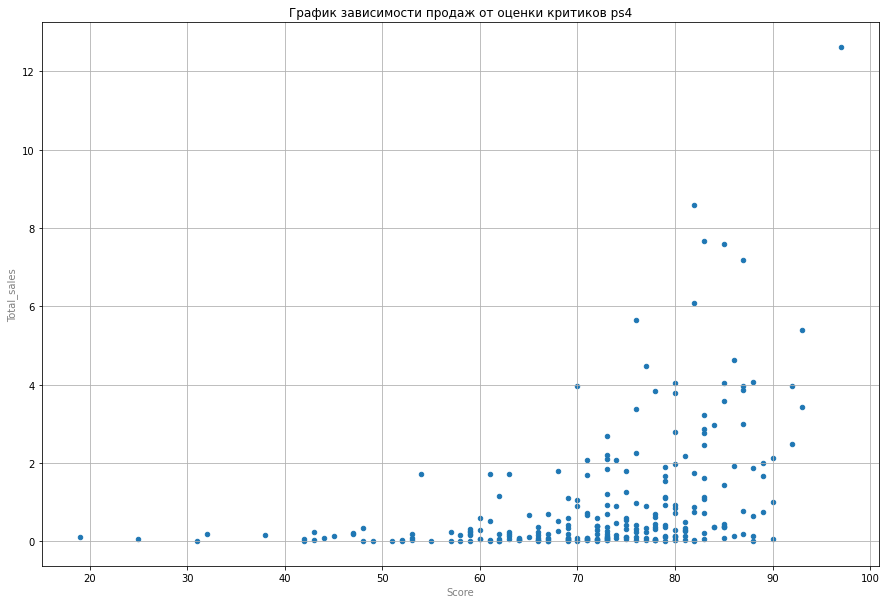

Корреляция ps4
              critic_score  user_score  total_sales
critic_score      1.000000    0.557654     0.406568
user_score        0.557654    1.000000    -0.031957
total_sales       0.406568   -0.031957     1.000000
-------------------------------------------------------------------------------------------------------------------


In [37]:
score_scatter("ps4")

По таблице можно сказать, что продажи больше зависят от критиков, чем от оценок обычных пользователей. Посмотрим, как обстоят дела на других платформах.

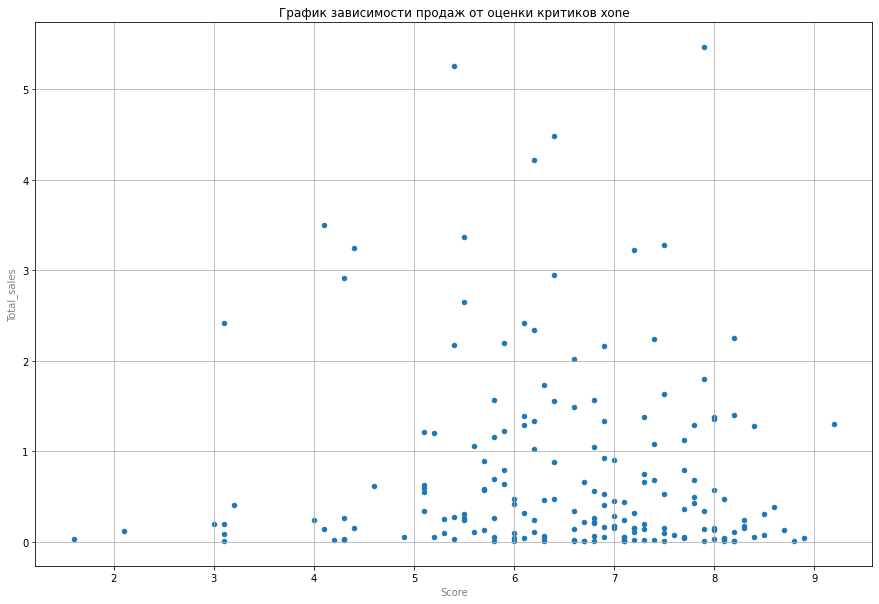

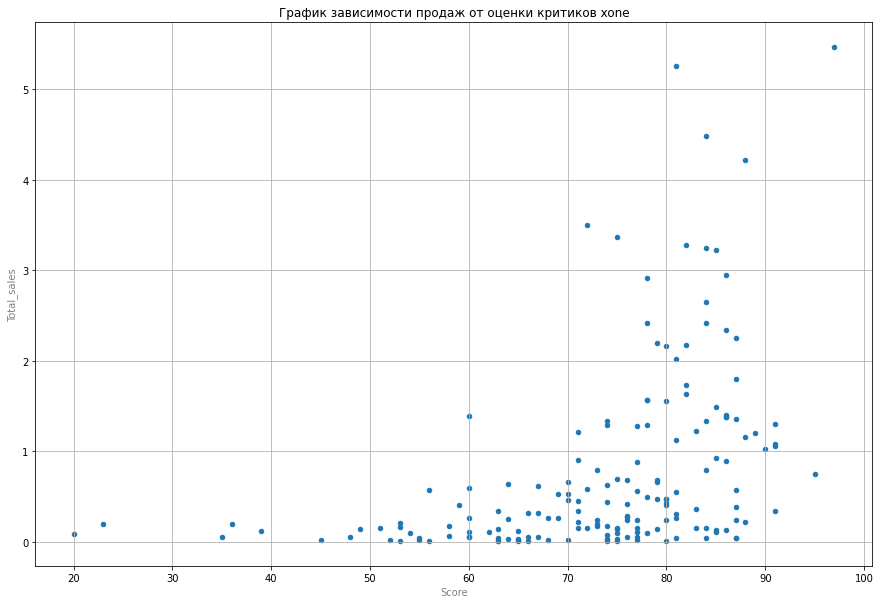

Корреляция xone
              critic_score  user_score  total_sales
critic_score      1.000000    0.472462     0.416998
user_score        0.472462    1.000000    -0.068925
total_sales       0.416998   -0.068925     1.000000
-------------------------------------------------------------------------------------------------------------------


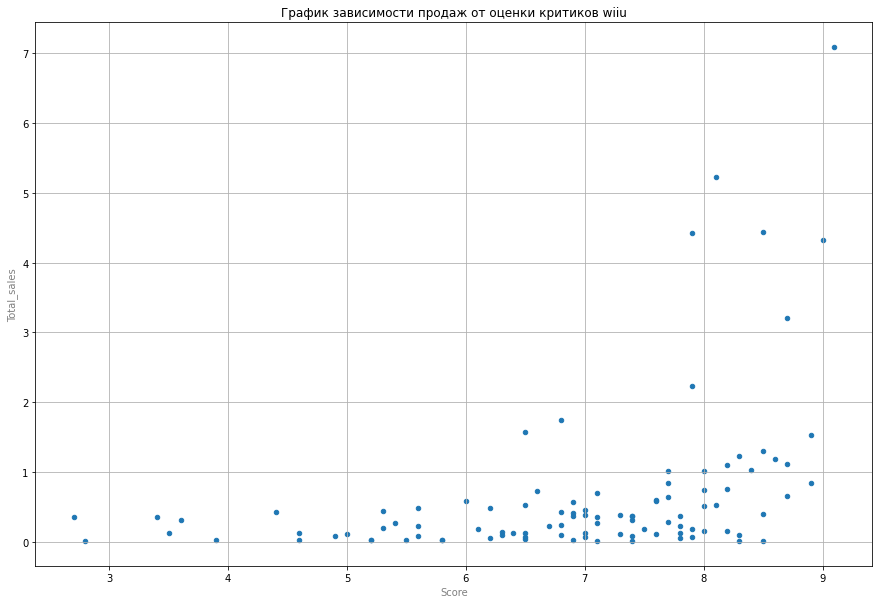

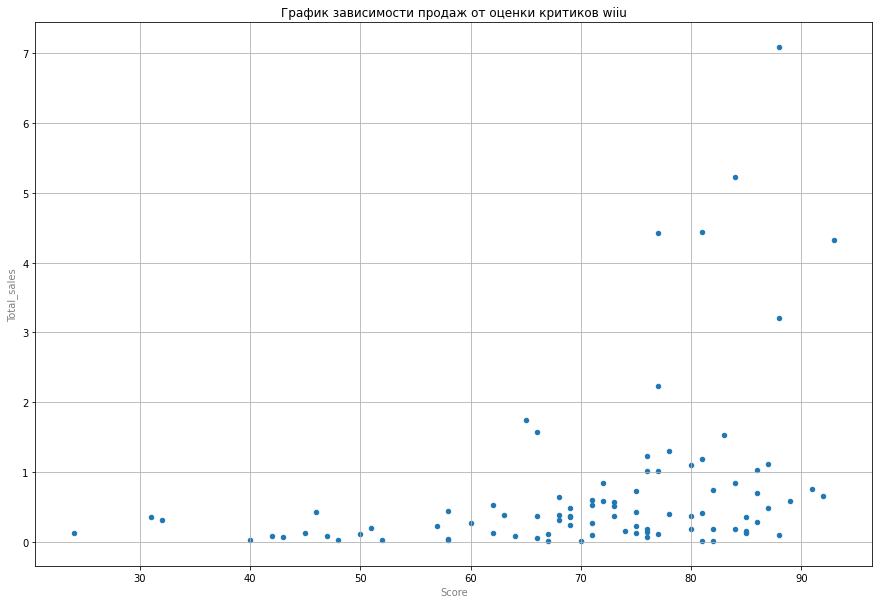

Корреляция wiiu
              critic_score  user_score  total_sales
critic_score       1.00000    0.770080     0.348380
user_score         0.77008    1.000000     0.400219
total_sales        0.34838    0.400219     1.000000
-------------------------------------------------------------------------------------------------------------------


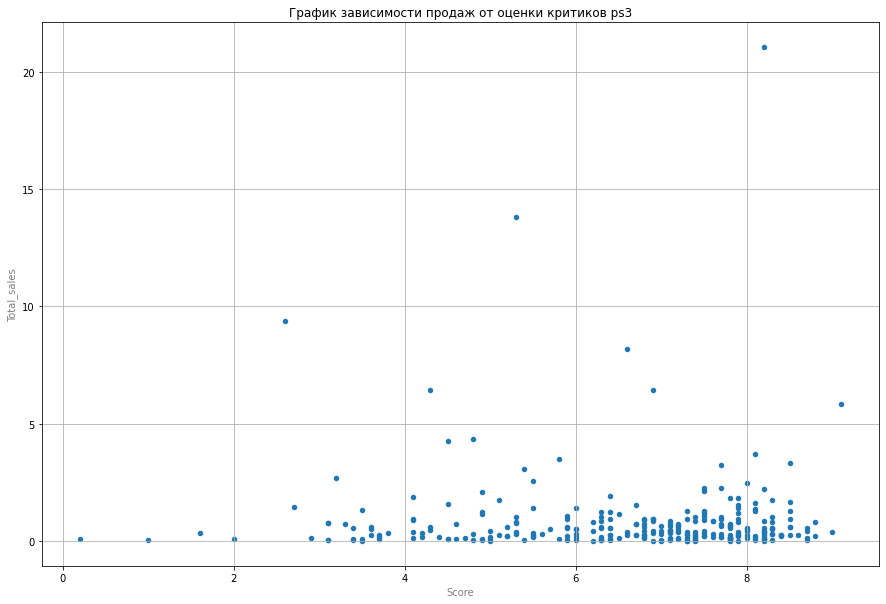

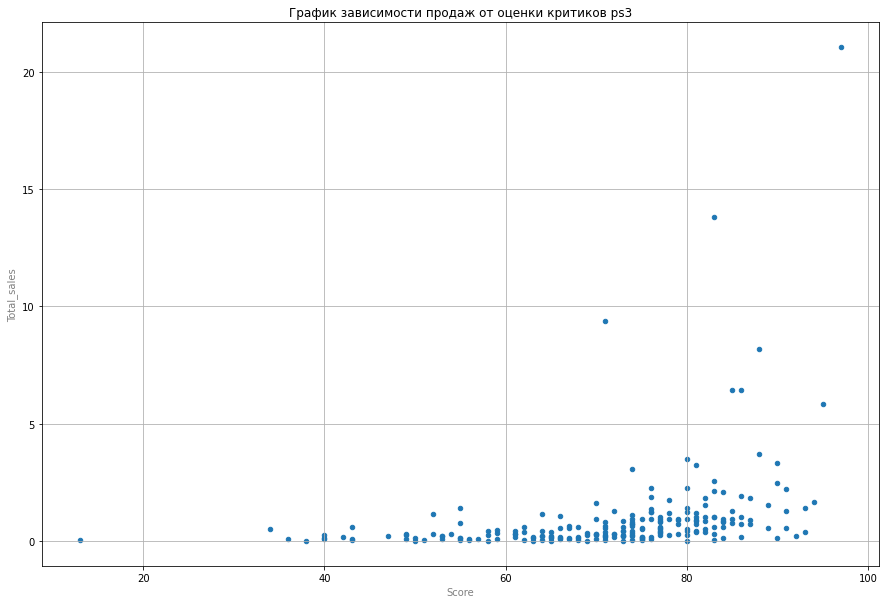

Корреляция ps3
              critic_score  user_score  total_sales
critic_score      1.000000    0.544510     0.334152
user_score        0.544510    1.000000    -0.006206
total_sales       0.334152   -0.006206     1.000000
-------------------------------------------------------------------------------------------------------------------


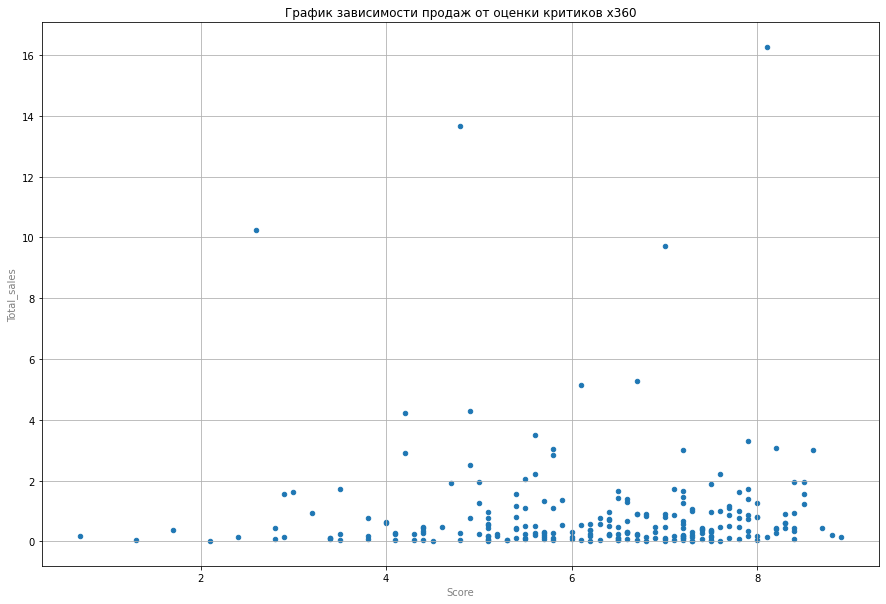

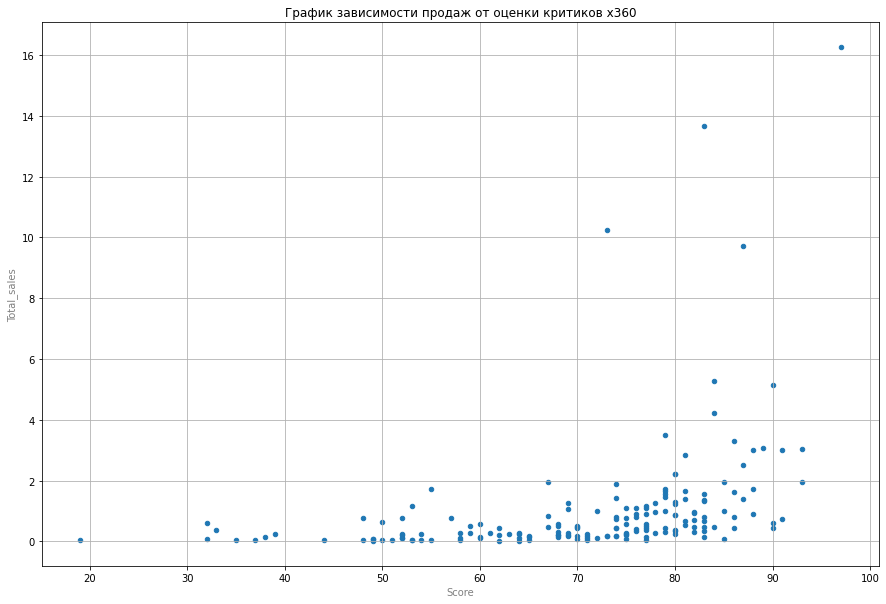

Корреляция x360
              critic_score  user_score  total_sales
critic_score      1.000000    0.557352     0.360573
user_score        0.557352    1.000000     0.006164
total_sales       0.360573    0.006164     1.000000
-------------------------------------------------------------------------------------------------------------------


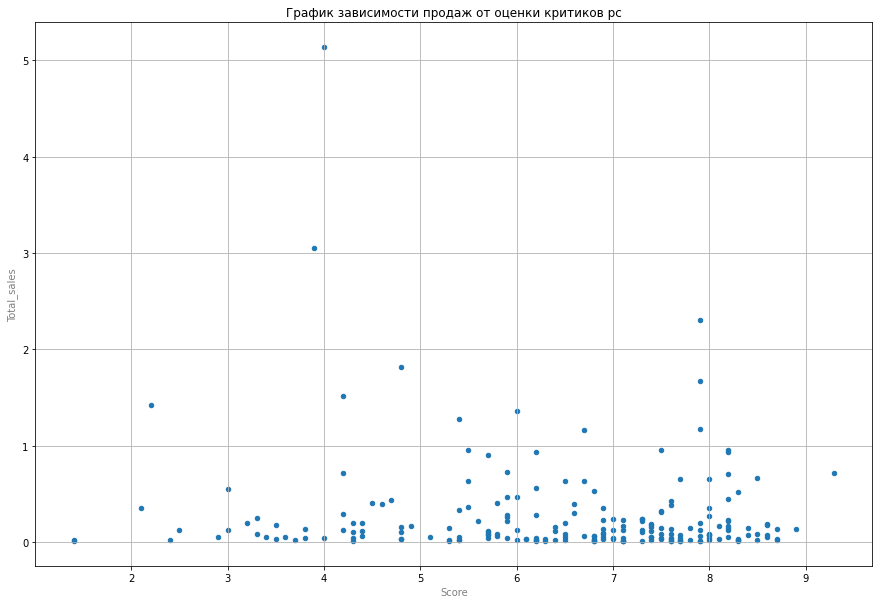

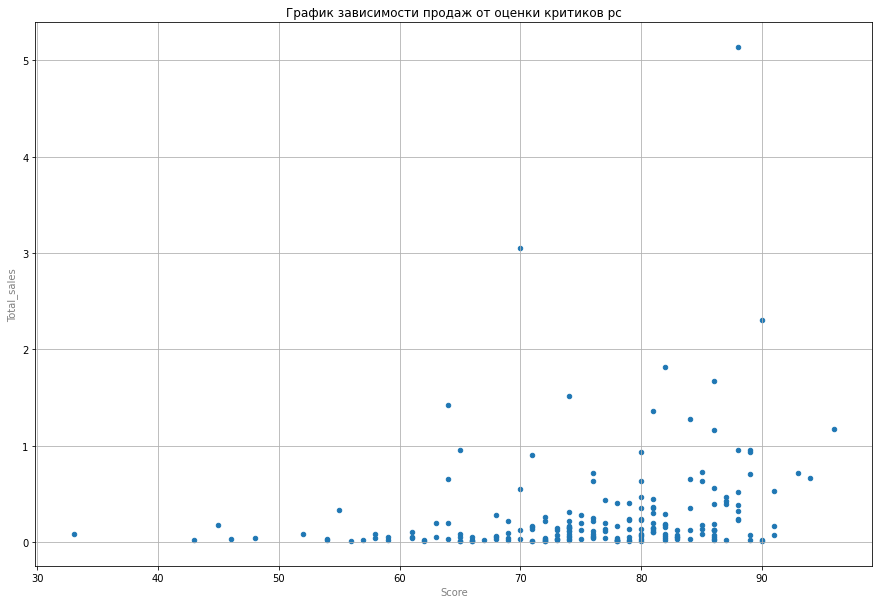

Корреляция pc
              critic_score  user_score  total_sales
critic_score      1.000000    0.432587     0.237243
user_score        0.432587    1.000000    -0.121867
total_sales       0.237243   -0.121867     1.000000
-------------------------------------------------------------------------------------------------------------------


In [38]:
platform_list = ["xone", "wiiu", "ps3", "x360", "pc"]

for plat in platform_list:
    score_scatter(plat)

В целом везде одна ситуация - можно сказать, что оценки критиков влияют на продажи, в то время как оценки пользователей скроее не влияют. Но есть и исключения, продажи игр на wiiu больше зависят от оценок пользователей! 

### Посмотрим на общее распределение игр по жанрам. 

Смотрим самые популярные игровые жанры по продажам.

In [39]:
pd.set_option('display.max_rows', None)
genre_check_direct = explore_period.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'median').sort_values(ascending = False, by = 'total_sales').reset_index()
print(genre_check_direct)
pd.set_option('display.max_rows', 16)

           genre  total_sales
0        shooter        0.440
1         sports        0.240
2       platform        0.210
3   role-playing        0.140
4         racing        0.140
5       fighting        0.130
6         action        0.120
7           misc        0.120
8     simulation        0.120
9       strategy        0.080
10        puzzle        0.045
11     adventure        0.030


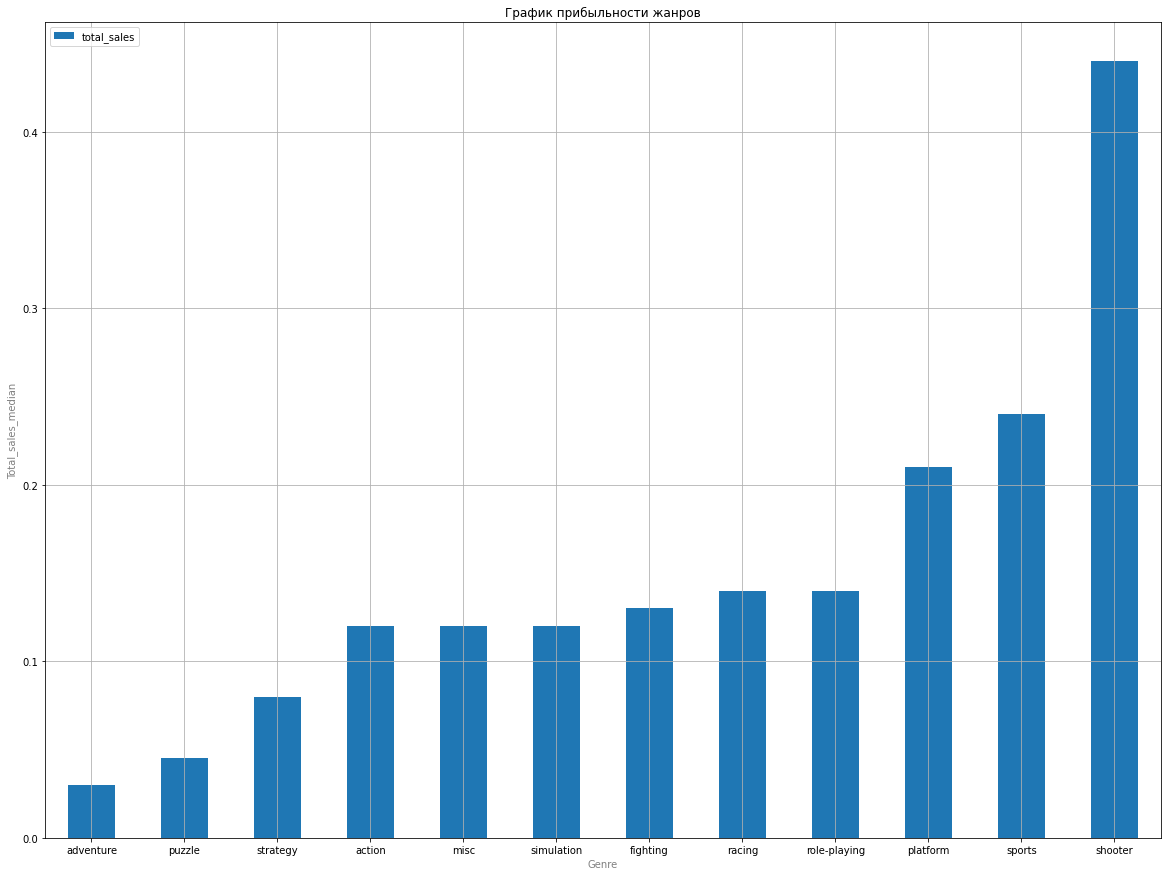

In [40]:
genre_check_direct.sort_values(ascending = True , by = 'total_sales').plot(kind = 'bar', x = 'genre', y = 'total_sales', figsize = (20,15), rot = 0)

plt.legend(loc=2)
plt.title('График прибыльности жанров')
plt.xlabel('Genre', color='gray')
plt.ylabel('Total_sales_median', color='gray')
plt.grid(True)
plt.show()

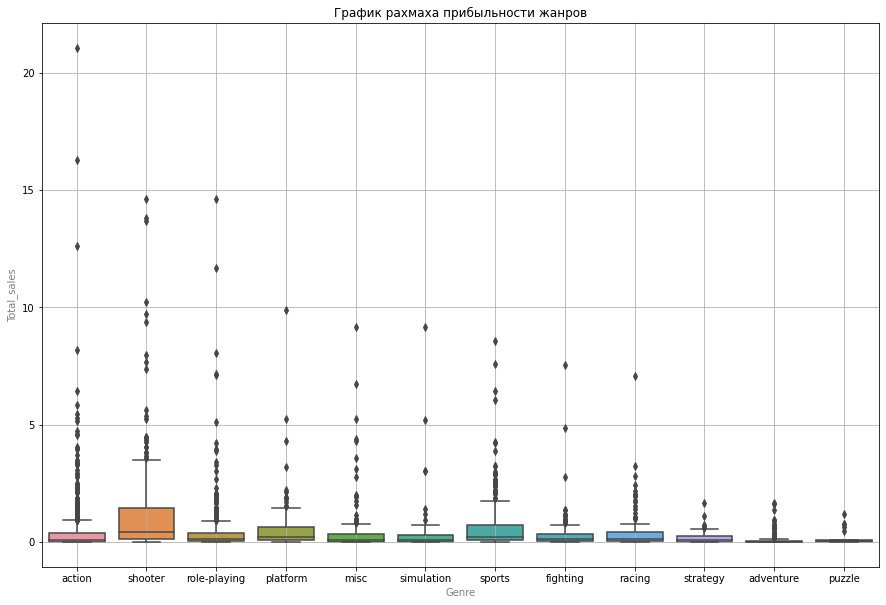

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))
 
sns.boxplot(data = explore_period, x = "genre", y = "total_sales", ax=ax)
plt.title('График рахмаха прибыльности жанров')
plt.xlabel('Genre', color='gray')
plt.ylabel('Total_sales', color='gray')
plt.grid(True)
plt.show()

Самые стабильно прибыльные жанры - `shooter` - в лидерах, `sports` и `platform` идут следом, но разница уже не столт большая. Чаще всего игры с этими метками крупнобюджетные, поэтому и внимание к себе привлекают больше.

Наименее прибыльные жанры - `adventure` и `puzzle`.

**Вывод:**

Провели исследовательский анализ данных, из которого узнали про количество игр, выпускаемых по годам. Узнали платформы с наибольшими продажами, выявили актуальные платформы на 2017 год. Выяснили влияние оценок игры на их продажи, и самые популярные жанры игр.

## Портрет пользователя каждого региона
Посмотрим на продажи игр по платформам по регионам.

In [42]:
users_portrait_platform = explore_period.pivot_table(index = 'platform', values = ['na_sales','eu_sales','jp_sales', 'other_sales'], aggfunc = 'sum')
users_portrait_platform = users_portrait_platform.sort_values(ascending=False, by = 'na_sales')
users_portrait_platform

,eu_sales,jp_sales,na_sales,other_sales
platform,,,,
x360,74.52,1.57,140.05,20.40
ps4,141.09,15.96,108.74,48.35
ps3,106.85,35.29,103.38,43.26
xone,51.59,0.34,93.12,14.27
3ds,42.64,87.79,55.31,8.87
wiiu,25.13,13.01,38.10,5.95
pc,37.76,0.00,19.12,5.77
wii,11.92,3.39,17.45,2.61
psv,11.36,21.04,10.98,5.80


In [43]:
eu_overall = users_portrait_platform['eu_sales'].sum()
jp_overall = users_portrait_platform['jp_sales'].sum()
na_overall = users_portrait_platform['na_sales'].sum()
other_overall = users_portrait_platform['other_sales'].sum()
overall = eu_overall + jp_overall + na_overall + other_overall

print('Рынок Северной Америки:', round(na_overall/overall*100), '%')
print('Рынок Европы:', round(eu_overall/overall*100), '%')
print('Рынок Японии:', round(jp_overall/overall*100), '%')
print('Рынок других стран:', round(other_overall/overall*100), '%')

Рынок Северной Америки: 41 %
Рынок Европы: 35 %
Рынок Японии: 13 %
Рынок других стран: 11 %


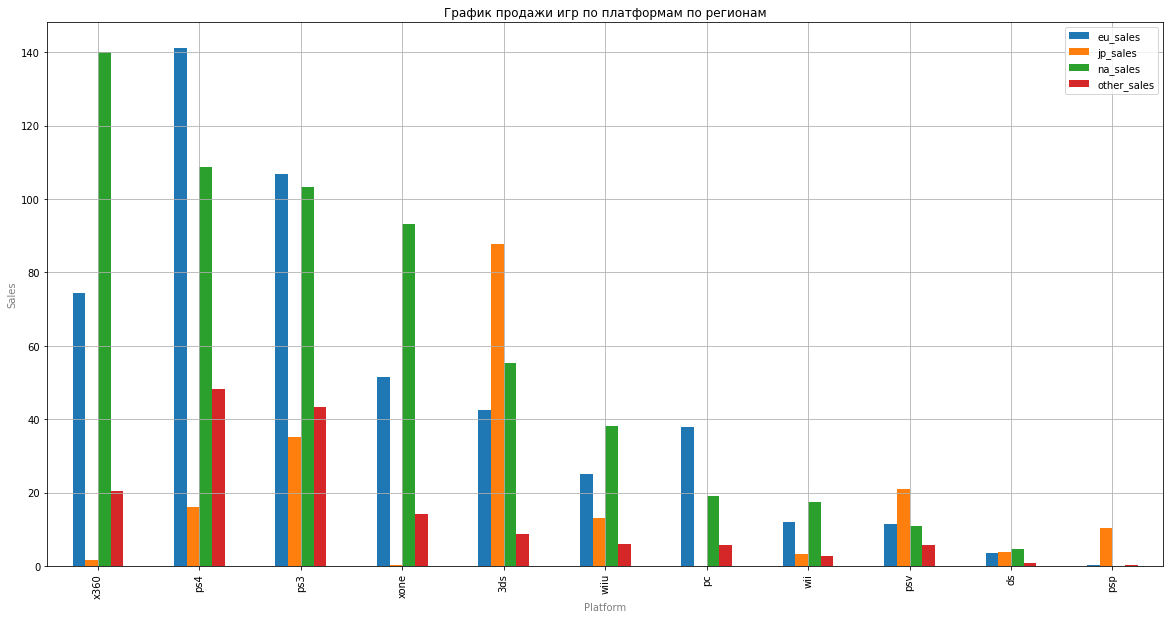

In [44]:
users_portrait_platform.plot(kind = 'bar', figsize=(20,10))

plt.legend(loc=1)
plt.title('График продажи игр по платформам по регионам')
plt.xlabel('Platform', color='gray')
plt.ylabel('Sales',color='gray')
plt.grid(True)
plt.show()

Видим, что лидер рынка - Северная Америка, затем идет Европа, а рынок игровых платформ Японии в процентном соотношении с хож со всеми оставшимися странами. Конкретно по платформам видим, что в Америке и Европе популярные платформы одинаковые. В Японии же популярны протативные консоли (их удобно брать с собой, а японцы, как мы знаем, очень занятой народ, вот и находят время в перерывах, чтобы немного отдохнуть), а остальной мир везде понемногу. 

Теперь посмотрим на прибыльность жанров по регионам.

In [45]:
users_portrait_income = explore_period.pivot_table(index = 'genre', values = ['na_sales','eu_sales','jp_sales', 'other_sales'], aggfunc = 'sum').sort_values(ascending=False, by = 'na_sales')
users_portrait_income

,eu_sales,jp_sales,na_sales,other_sales
genre,,,,
action,159.34,52.80,177.84,51.14
shooter,113.47,9.23,144.77,37.26
sports,69.08,8.01,81.53,22.44
role-playing,48.53,65.44,64.00,14.83
misc,26.32,12.86,38.19,7.67
platform,21.41,8.63,25.38,5.58
fighting,10.79,9.44,19.79,4.47
racing,27.29,2.50,17.22,6.49
adventure,9.46,8.24,8.92,2.81


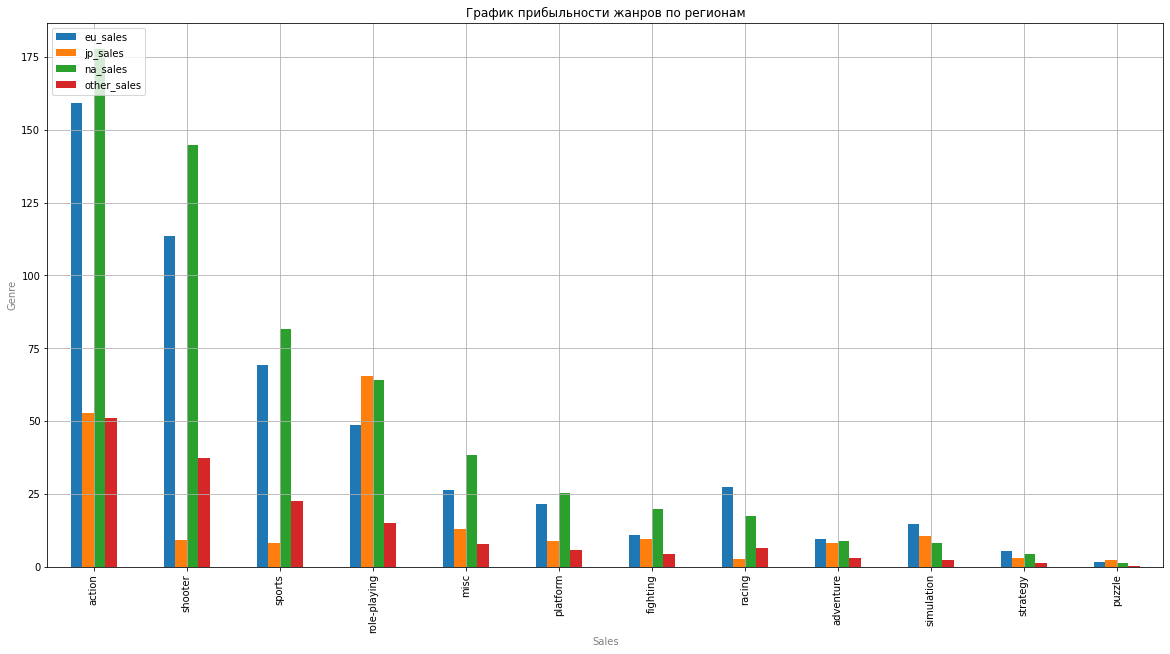

In [46]:
users_portrait_income.plot(kind = 'bar', figsize=(20,10))

plt.legend(loc=2)
plt.title('График прибыльности жанров по регионам')
plt.xlabel('Sales', color='gray')
plt.ylabel('Genre',color='gray')
plt.grid(True)
plt.show()

И опять наблюдаем схожесть американцев и европейцев, но теперь уже в предпочтениях жанра, другой мир разделяет их предпочтения. `Action`, `Sports`, `Shooter` - самые популярные жанры в этих странах . Любимый жанр японцев - `Role-Playing`. Видимо дело в тех же протативных консолях, в активные игры на них трудно играть.

Теперь посмотрим насколько влияет рейтинг на продажи.

In [47]:
ESRB = explore_period.pivot_table(index = 'rating', values = ['eu_sales','jp_sales','na_sales', 'other_sales'], aggfunc = 'sum').sort_values(ascending=False, by = 'na_sales')
ESRB

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
m,193.96,21.20,231.57,63.38
e,113.02,28.33,114.37,31.44
undefined,91.50,108.84,103.31,27.17
e10+,55.37,8.19,75.70,16.23
t,52.96,26.02,66.02,17.94


Как мы видим игровые студии сильно опасаются делать игры для маленьких детей (`ec`), и с рейтингом 18+(`ao`). Это может быть связано с тем, что игры с рейтингом `ес` банально не интересны, и дети в них не играют, а игры рейтинга `ао` могут ограничиваться в распространении государством и быть не доступны для целевой аудитории.

**Вывод:**

Пользователи Европы и Северной Америки и других стран играют примерно в одни и те же консоли и жанры, и игровая индустрия больше развита в домашнем уюте, а в Японии преобладают пользователи с портативными консолями, в которые можно играть не только дома, поэтому и популярные жанры у них другие. А рейтинг, безусловно, влияет на продажи игр.

## Проверьте гипотезы

1-ая гипотиза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

In [48]:
pre_xone = explore_period.query('user_score > 0')
xone = pre_xone[pre_xone['platform'] == 'xone']['user_score']
print(xone.mean())

pre_pc = explore_period.query('user_score > 0')
pc = pre_pc[pre_pc['platform'] == 'pc']['user_score']
print(pc.mean())

6.521428571428572
6.4286407766990274


Формулируем нулевую и альтернативную гипотизы, исходя из данной нам 1-ой гипотизы.

`H0`: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

`H1`: Средние пользовательские рейтинги платформ Xbox One и PC разные.

In [49]:
# проверяем первую гипотезу

alpha = 0.01

results = st.ttest_ind(xone, pc, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


**Вывод:**

1-ая гипотеза не подтвердилась.

2-ая гипотиза: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Применим t-критерий Стюдента, который используется для сравнения средних арифметических двух групп.

In [50]:
pre_action = explore_period.query('user_score > 0')
action = pre_action[pre_action['genre'] == 'action']['user_score']
print(action.mean())

pre_sports = explore_period.query('user_score > 0')
sports = pre_sports[pre_sports['genre'] == 'sports']['user_score']
print(sports.mean())

6.825047801147227
5.455670103092784


Формулируем нулевую и альтернативную гипотизы, исходя из данной нам 2-ой гипотизы.

`H0`: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

`H1`: Средние пользовательские рейтинги жанров Action и Sports разные.

Применим t-критерий Стюдента, который используется для сравнения средних арифметических двух групп.

In [51]:
# проверяем вторую гипотезу

alpha = 0.01

results = st.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.989458066467418e-20
Отвергаем нулевую гипотезу


**Вывод:**

На имеющихся данных, на уровне значимости 1% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.

## Напишите общий вывод

Мы подготовили наши данные, привели к правильным данным столбцы. Проведя анализ, мы выявили, что количество игр на различные платформы расло на протяжении всего периода, и их производства стало падать с 2012 года. Также мы выявили, что средняя продолжительность жизни игровой платформы составляет 7-8 лет. Больше всех поиграть любят пользователи из Северной Америки. Самый популярный жанр за исследуемый период: `Action`, жанр `Strategy` не пользуется популярностью. Наблюдается взаимосвязь между продажами и оценками критиков.

В конечном счете, выделели критерии определяющие успешность игры:

    - Регион.
    - Рейтинг ассоциации, определяющей возрастной рейтинг компьютерных игр.
    - Платформа, которая наиболее распространена в данном регионе.
    - Жанр.
    - Рейтинг критиков.
 

    

    
